In [23]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

In [58]:
SOURCE_VIDEO_PATH = "video/bacheha.mp4"
TARGET_VIDEO_PATH = "test/vehicles-result-4.mp4"
CONFIDENCE_THRESHOLD = 0.1
IOU_THRESHOLD = 0.1
MODEL_NAME = "yolov10x.pt"
MODEL_RESOLUTION = 1280

In [59]:
SOURCE = np.array([
    [50, 400],
    [900, 400],
    [900, 1400],
    [-900, 1400]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 350

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [60]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

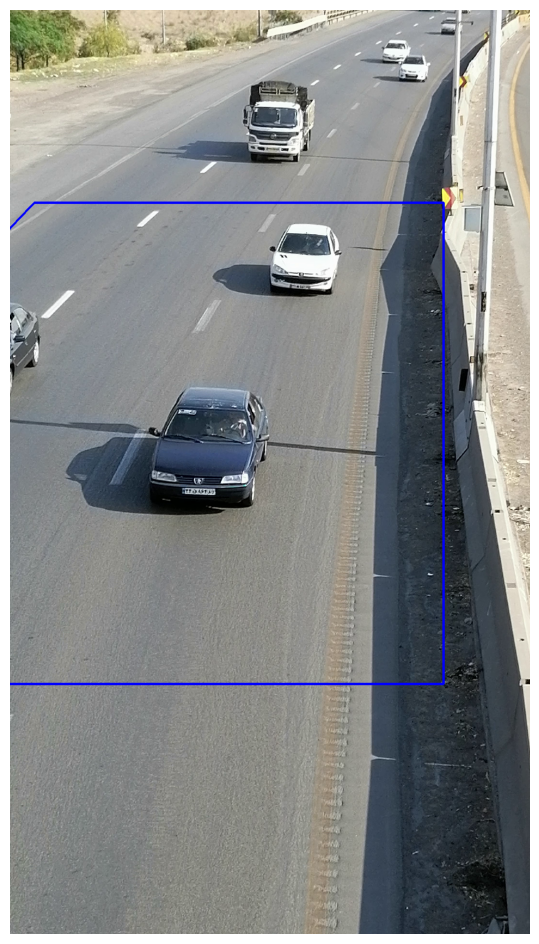

In [61]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.BLUE, thickness=4)
sv.plot_image(annotated_frame)

In [62]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [63]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)


In [64]:
import torch
torch.cuda.is_available()

True

In [69]:
import torch
device = torch.device('cuda')

# Load YOLO model on GPU
model = YOLO(MODEL_NAME).to(device)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps)

# annotators configuration
# thickness = sv.calculate_dynamic_line_thickness(
#     resolution_wh=video_info.resolution_wh
# )
# text_scale = sv.calculate_dynamic_text_scale(
#     resolution_wh=video_info.resolution_wh
# )
bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    text_scale=2,
    text_thickness=2,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=2,
    trace_length=video_info.fps * 800,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        # detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        # detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # format labels
        labels = []

        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time 
                labels.append(f"{int(speed*2553)} km/h")

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )
        # add frame to target video
        # sink.write_frame(annotated_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        cv2.imshow('haha', annotated_frame)
        
        # cap.release()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
 12%|█▏        | 120/968 [00:31<03:40,  3.84it/s]


In [58]:
import supervision